In [1]:
import edward as ed
import tensorflow as tf
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from functools import reduce
from edward.models import Normal

%matplotlib inline

In [2]:
# sample data
def gen_time_series(n_points):
    time_series = np.array([[np.random.normal(mu*i, sigma*i), 
                        np.random.normal(mu*i, sigma*i/4)] 
                       for i in range(n_points)])
    return time_series

(100, 100, 2)
20000 data values


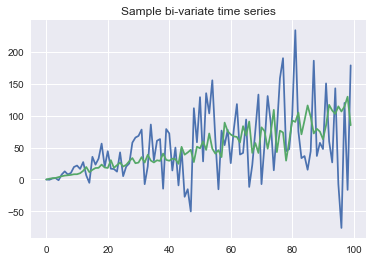

In [13]:
GLOBAL_SEED=1
TESTING=0

mu=1
sigma=1
n_series=100
n_points = 100
n_features = 2
# multi-variate time-series: 
# x_t ~ [Gaussian(mu*t,sigma*t), Gaussian(mu*t,sigma*t/4)]
# Points X Time X Features
x_data = np.zeros((n_series,n_points,n_features), dtype=np.float32)
for i in range(n_series):
    x_data[i] = gen_time_series(n_points)

if TESTING: x_data_test=x_data[:10]
plt.title("Sample bi-variate time series")
for i in range(n_features):
    plt.plot(x_data[0,:,i]);
print(x_data.shape)
print(reduce(lambda x,y: x*y, list(x_data.shape)), "data values")

x_train = x_data[:70]
x_validate = x_data[70:90]
x_test = x_data[-10:]

In [4]:
# wrapper around tf.get_variable that checks if the variable has already been defined.
# useful for playing around in jupyter. allows you to call cells multiple times
def get_variable_wrap(*args, **kwargs):
    try:
        return tf.get_variable(*args, **kwargs)
    except ValueError:
        tf.get_variable_scope().reuse_variables()
        return tf.get_variable(*args, **kwargs)

def fc_act(x, next_layer_size, act=None, name="fc"):
    nbatches = x.get_shape()[0]
    prev_layer_size = x.get_shape()[1]
    with tf.name_scope("fc"):
        w = get_variable_wrap("weights", [prev_layer_size, next_layer_size], dtype=tf.float32, initializer=tf.random_normal_initializer())
        b = get_variable_wrap("bias", [next_layer_size], dtype=tf.float32, initializer=tf.constant_initializer(0.1))
        o = tf.add(tf.matmul(x, w), b)
        if act: return act(o)
        else: return o

# LSTM Cell

In [5]:
def init_lstm_cell(rnn_size, batch_size):
    with tf.variable_scope("lstm"):
        try:
            cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True)
        except:
            cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True, reuse=True)
        # get initial_state of rnn
        state = cell.zero_state(batch_size, tf.float32)
    return cell, state

# Prior

In [6]:
def get_prior(rnn_hidden, prior_size, z_size):
    with tf.variable_scope("prior"):
        with tf.variable_scope("prior"):
            prior = fc_act(rnn_hidden, prior_size, act=tf.nn.relu)
        with tf.variable_scope("prior_mu"):
            prior_mu = fc_act(prior, z_size)
        with tf.variable_scope("prior_sigma"):
            prior_sigma = fc_act(prior, z_size, act=tf.nn.softplus)
    return [prior, 
            prior_mu, 
            prior_sigma]

# Generation

In [7]:
def get_decoding(rnn_hidden, theta_size, x_size):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("theta"):
            theta = fc_act(rnn_hidden, theta_size, act=tf.nn.relu)
        with tf.variable_scope("theta_mu"):
            theta_mu = fc_act(theta, x_size)
        with tf.variable_scope("theta_sigma"):
            theta_sigma = fc_act(theta, x_size, act=tf.nn.softplus)
    return [theta,
            theta_mu,
            theta_sigma]

# Latent RNN Recurrence

In [8]:
def vrnn_recurrence(rnn_cell, z_1, state):
    try:
        return rnn_cell(z_1, state, "rnn")
    except:
        tf.get_variable_scope().reuse_variables()
        return rnn_cell(z_1, state, "rnn")

# Latent RNN Class

In [15]:
class VRNN(object):
    """docstring for VRNN"""
    def __init__(self, x_t, batch_size, rnn_size, x_size, x_1_size, 
               z_size, z_1_size, phi_size, prior_size, theta_size):
        self.x_t = x_t # place holder for time-series
        self.batch_size = batch_size
        self.rnn_size = rnn_size
        self.x_size = x_size
        self.x_1_size = x_1_size
        self.z_size = z_size
        self.z_1_size = z_1_size
        self.phi_size = phi_size
        self.prior_size = prior_size
        self.theta_size = theta_size
        
        self.cell, self.state = init_lstm_cell(rnn_size, batch_size)
        print ("cell", self.cell)
        print ("state", self.state)
        self._build()

    def reset_cell(self): 
        self.state = self.cell.zero_state(self.batch_size, tf.float32)
    
    def _vrnn_step(self, vals, x_t):
        # get latest values
        # I chose to store them all but you don't HAVE to do this. 
        # This is a convenient thing to do however so you can check values later on
        cell_state = vals[0]

        prev_hidden = vals[1]

        # mu_phi, sigma_phi = f(ht-1)
        prior_vals = [prior, 
                prior_mu, 
                prior_sigma] = \
                    get_prior(prev_hidden, self.prior_size, self.z_size)
        
        # sample from prior
        epsilon = tf.random_normal(shape=[x_t.get_shape().as_list()[0], z_size], seed=GLOBAL_SEED)
        # z = mu + epsilon*sigma
        z_t = tf.add(prior_mu, tf.multiply(epsilon, prior_sigma))
          
        z_1 = fc_act(z_t, z_1_size, act=tf.nn.relu)
            
        cell_output, cell_state = vrnn_recurrence(self.cell, z_1, prev_hidden)

        # mu_x , sigma_x = f(ht)
        decoding_vals = [theta,
                theta_mu,
                theta_sigma] = \
                    get_decoding(prev_hidden,self.theta_size, self.x_size)

        return (cell_state[0],
                cell_state[1],
                cell_output
               )
    
    def _build(self):
        self.output = self._scan_sequence(tf.transpose(self.x_t, [1, 0, 2]))
        self.nll = negative_log_likelihood_gaussian(self.x_t, output[-2], output[-1])
        self.klgg = kl_gaussian_gaussian(output[4], output[5], 
                                    output[7], output[8])
        self.objective = tf.add(tf.reduce_mean(nll),tf.reduce_mean(klgg))
        self.train_op = get_optimizer(self.objective)
    
    def _scan_sequence(self, sequence):
        return tf.scan(self._vrnn_step, sequence, initializer=(
                self.state[0], # cell_state - 0,
                self.state[1] # hidden_state - 1,
        ))

# Setting for VRNN

In [17]:
# test computing latent variable
batch_size=10
rnn_size=20

x_size=x_data.shape[1]
x_1_size=x_data.shape[1]

z_size=15
z_1_size=15

phi_size = 25   # N ~ q(z|x)
prior_size = 25 # N ~ p(z)
theta_size = 25 # N ~ p(x|z)

#get shape
x_t_shape = list(x_data.shape)
nbatches=max(x_t_shape[0]//batch_size,1)
x_t_shape[0] = int(max(x_t_shape[0]/nbatches,1))
print("nbatches", nbatches)
print("input shape", x_t_shape)
# input
x_t = tf.placeholder(tf.float32, shape=x_t_shape, name="x_t")

vrnn = VRNN(x_t, batch_size, rnn_size, x_size, x_1_size, 
       z_size, z_1_size, phi_size, prior_size, theta_size)

nbatches 10
input shape [10, 100, 2]
cell <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x12564d9e8>
state LSTMStateTuple(c=<tf.Tensor 'lstm_4/LSTMCellZeroState/zeros:0' shape=(10, 20) dtype=float32>, h=<tf.Tensor 'lstm_4/LSTMCellZeroState/zeros_1:0' shape=(10, 20) dtype=float32>)


TypeError: 'Tensor' object is not iterable.